In [114]:
from eval import *

import pandas as pd
import torch
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from preprocessing import create_split
from pmf import PMF
from lr import LogReg
import pickle

data = pd.read_csv('data/men_data.csv')
REPLACEMENT_LEVELS = [500,1000]
SEED = 42

train, test = create_split(data, SEED)

In [105]:
models = []

pd.DataFrame(columns = ['model_type', 'replacement_level', 'num_factors', 'model'])
models

[]

# ------

In [106]:
import os
from glob import glob 

lr_files = glob('models/lr/model_*_fold_*.pkl') 
pmf_files = glob('models/pmf/model_*_*_fold_*.pth')
pmf_files
models = []

In [54]:
lr_model['model']

In [160]:
models=[]

In [161]:
for file in lr_files: 
    with open(file, 'rb') as f:
        lr_model = pickle.load(f)
        val_ind = lr_model['val_indices'] 
        # get the replacemnet level and fold num from the naming convention
        file_name = os.path.basename(file)
        file_root, _ = os.path.splitext(file_name)
        replacement_level, fold = map(int, file_root.split('_')[1::2]) # basically takes the 2nd and 4th elements of the split string (the replacement level and fold number) and turns it to an int
        
        train_df = data.iloc[~val_ind] # not the validation set
        test_df = data.iloc[val_ind] # the validation set
        model = lr_model['model']
        train_res = analyze_model(model, train_df)
        test_res = analyze_model(model, test_df)
        # for dataset, results in [('train', train_res), ('test', test_res)]:
        #     models.append({
        #         'model_type': 'lr',
        #         'replacement_level': replacement_level,
        #         'fold': fold,
        #         'num_factors': None,
        #         **results # unpack the results dict 
        #     })

        models.append({
            'model_type': 'lr',
            'replacement_level': replacement_level,
            'k_fold': fold,
            'num_factors': np.nan,
            'dataset': 'train',
            **train_res # unpack the results dict 
        })
        models.append({
            'model_type': 'lr',
            'replacement_level': replacement_level,
            'k_fold': fold,
            'num_factors': np.nan,
            'dataset': 'test',
            **test_res
        })


In [122]:
from pmf import PMF
torch.load('models/pmf/model_2_1000_fold_1.pth')
PMF.load_state_dict()

{'model_state_dict': OrderedDict([('climber_embedding.weight',
               tensor([[0.1956, 0.3363]])),
              ('problem_embedding.weight',
               tensor([[ 0.8230,  0.3072],
                       [-0.3358, -0.8703],
                       [-0.5166, -1.6771],
                       ...,
                       [ 1.3380,  1.3849],
                       [-2.8902,  0.8673],
                       [-0.1920,  0.3278]]))]),
 'val_indices': array([    4,    35,    39, ..., 76159, 76178, 76182]),
 'climber_vocab': Vocab(),
 'problem_vocab': Vocab()}

In [124]:
model = PMF(df=data, replacement_level=replacement_level, num_factors=num_factors)
model.climber_vocab.get_itos()

['other',
 'Jernej Kruder',
 'Rustam Gelmanov',
 'Sean Mccoll',
 'Dmitrii Sharafutdinov',
 'Tsukuru Hori',
 'Jan Hojer',
 'Guillaume Glairon Mondet',
 'Kokoro Fujii',
 'Kilian Fischhuber',
 'Aleksei Rubtsov']

In [130]:
import inspect

print(inspect.getsource(PMF.__init__))

    def __init__(self, df, climber_vocab=None, problem_vocab=None, replacement_level=500, num_factors=1):
        super(PMF, self).__init__()
        if climber_vocab is None:
            self.climber_vocab = build_vocab_from_iterator([df['Name'].values], min_freq=replacement_level, specials=['other'])
            self.climber_vocab.set_default_index(self.climber_vocab['other'])
        else:
            self.climber_vocab = climber_vocab
        
        if problem_vocab is None:
            self.problem_vocab = build_vocab_from_iterator([df['Problem_ID'].values], min_freq=num_factors, specials=['Problem'])
            self.problem_vocab.set_default_index(self.problem_vocab['Problem'])
        else:
            self.problem_vocab = problem_vocab

        self.climber_embedding = nn.Embedding(len(self.climber_vocab), num_factors)
        self.problem_embedding = nn.Embedding(len(self.problem_vocab), num_factors)



In [162]:
for file in pmf_files:
    pmf_model = torch.load(file)
    file_name = os.path.basename(file)
    file_root, _ = os.path.splitext(file_name)
    split = file_root.split('_')
    num_factors, replacement_level, fold = map(int, [split[1], split[2], split[4]])

    model = PMF(data, pmf_model['climber_vocab'], pmf_model['problem_vocab'], replacement_level, num_factors)
    
    model.load_state_dict(pmf_model['model_state_dict']) # load the model that was saved
    val_ind = pmf_model['val_indices']

    train_df = data.iloc[~val_ind]
    test_df = data.iloc[val_ind]

    train_res = analyze_model(model, train_df)
    test_res = analyze_model(model, test_df)

    # for dataset, results in [('train', train_res), ('test', test_res)]:
    #     models.append({
    #         'model_type': 'pmf',
    #         'replacement_level': replacement_level,
    #         'fold': fold,
    #         'num_factors': int(num_factors),
    #         **results
    #     })
    models.append({
        'model_type': 'pmf',
        'replacement_level': replacement_level,
        'k_fold': fold,
        'num_factors': int(num_factors),
        'dataset': 'train',
        **train_res # unpack the results dict 
    })
    models.append({
        'model_type': 'pmf',
        'replacement_level': replacement_level,
        'k_fold': fold,
        'num_factors': int(num_factors),
        'dataset': 'test',
        **test_res
    })

In [163]:
pd.DataFrame(models)

,model_type,replacement_level,k_fold,num_factors,dataset,Accuracy,Log Loss,Brier Score,F1 Score,ROC Score
0,lr,500,5,NaN,train,0.550961,0.652244,0.230959,0.444011,0.600009
1,lr,500,5,NaN,test,0.586205,0.665240,0.236714,0.444542,0.600403
2,lr,500,4,NaN,train,0.552340,0.653761,0.231604,0.437536,0.598645
3,lr,500,4,NaN,test,0.582136,0.663248,0.235777,0.458634,0.602394
4,lr,500,1,NaN,train,0.551253,0.654363,0.231846,0.439048,0.597732
5,lr,500,1,NaN,test,0.585707,0.662409,0.235428,0.459642,0.604761
6,lr,500,3,NaN,train,0.556212,0.652393,0.231078,0.442171,0.601389
7,lr,500,3,NaN,test,0.591127,0.659860,0.234193,0.465328,0.608919
8,lr,500,2,NaN,train,0.550335,0.654749,0.232111,0.435771,0.596634
9,lr,500,2,NaN,test,0.580194,0.662255,0.235346,0.454041,0.601942


# -----

In [3]:
pmf_model = torch.load('models/pmf/model_1_500.pth')
models = []

pd.Series(
    {
        'model_type': 'pmf',
        'replacement_level': '500',
        'num_factors': '1',
        'model': pmf_model
    }
)

model_type                                                         pmf
replacement_level                                                  500
num_factors                                                          1
model                PMF(\n  (climber_vocab): Vocab()\n  (problem_v...
dtype: object

In [4]:
REPLACEMENT_LEVELS = [500,1000]
LATENT_FACTORS = 2

models = []

for replacement_level in REPLACEMENT_LEVELS:
    with open(f"models/lr/model_{replacement_level}.pkl", 'rb') as f:
        lr_model = pickle.load(f)
    models.append({
        'model_type': 'lr',
        'replacement_level': replacement_level,
        'num_factors': np.nan,
        'model': lr_model
    })
    
    for num_factors in np.arange(1, LATENT_FACTORS+1):
        pmf_model = torch.load(f"models/pmf/model_{num_factors}_{replacement_level}.pth")
        pmf_model.eval()
        models.append({
            'model_type': 'pmf',
            'replacement_level': replacement_level,
            'num_factors': num_factors,
            'model': pmf_model
        })

pd.DataFrame(models)

,model_type,replacement_level,num_factors,model
0,lr,500,NaN,<lr.LogReg object at 0x0000019EE53B7590>
1,pmf,500,1.0,PMF(\n (climber_vocab): Vocab()\n (problem_v...
2,pmf,500,2.0,PMF(\n (climber_vocab): Vocab()\n (problem_v...
3,lr,1000,NaN,<lr.LogReg object at 0x0000019EAE22AC90>
4,pmf,1000,1.0,PMF(\n (climber_vocab): Vocab()\n (problem_v...
5,pmf,1000,2.0,PMF(\n (climber_vocab): Vocab()\n (problem_v...


In [5]:
results = pd.DataFrame(models).assign(
    train_results = lambda d: d.model.apply(lambda x: analyze_model(x, train)),
    test_results = lambda d: d.model.apply(lambda x: analyze_model(x, test)),
)

results

,model_type,replacement_level,num_factors,model,train_results,test_results
0,lr,500,NaN,<lr.LogReg object at 0x0000019EE53B7590>,"{'Accuracy': 0.5649257747384725, 'Log Loss': 0...","{'Accuracy': 0.5623457762377277, 'Log Loss': 0..."
1,pmf,500,1.0,PMF(\n (climber_vocab): Vocab()\n (problem_v...,"{'Accuracy': 0.7430270256080433, 'Log Loss': 0...","{'Accuracy': 0.726256103323358, 'Log Loss': 0...."
2,pmf,500,2.0,PMF(\n (climber_vocab): Vocab()\n (problem_v...,"{'Accuracy': 0.7678344074448397, 'Log Loss': 0...","{'Accuracy': 0.740221557200609, 'Log Loss': 0...."
3,lr,1000,NaN,<lr.LogReg object at 0x0000019EAE22AC90>,"{'Accuracy': 0.556118497906467, 'Log Loss': 0....","{'Accuracy': 0.5522129469207749, 'Log Loss': 0..."
4,pmf,1000,1.0,PMF(\n (climber_vocab): Vocab()\n (problem_v...,"{'Accuracy': 0.7432632863874414, 'Log Loss': 0...","{'Accuracy': 0.7275161442746889, 'Log Loss': 0..."
5,pmf,1000,2.0,PMF(\n (climber_vocab): Vocab()\n (problem_v...,"{'Accuracy': 0.7521099400160133, 'Log Loss': 0...","{'Accuracy': 0.7291961988764635, 'Log Loss': 0..."


In [6]:
metrics = pd.concat([
    pd.concat(
        [
            results[['model_type', 'replacement_level', 'num_factors']],
            results['train_results'].apply(pd.Series).assign(dataset = "train")
        ], axis = 1
    ),
    pd.concat(
        [
            results[['model_type', 'replacement_level', 'num_factors']],
            results['test_results'].apply(pd.Series).assign(dataset = "test")
        ], axis = 1
    )
])

metrics

,model_type,replacement_level,num_factors,Accuracy,Log Loss,Brier Score,F1 Score,ROC Score,dataset
0,lr,500,NaN,0.564926,0.658004,0.233476,0.446711,0.599467,train
1,pmf,500,1.0,0.743027,0.503488,0.169359,0.771039,0.825015,train
2,pmf,500,2.0,0.767834,0.464609,0.154805,0.791336,0.854285,train
3,lr,1000,NaN,0.556118,0.680734,0.244059,0.714751,0.524360,train
4,pmf,1000,1.0,0.743263,0.505141,0.169781,0.773149,0.824337,train
5,pmf,1000,2.0,0.752110,0.487790,0.163744,0.779750,0.836807,train
0,lr,500,NaN,0.562346,0.660124,0.234469,0.433849,0.595353,test
1,pmf,500,1.0,0.726256,0.541383,0.180094,0.755004,0.803343,test
2,pmf,500,2.0,0.740222,0.554413,0.175507,0.764605,0.814851,test
3,lr,1000,NaN,0.552213,0.681890,0.244584,0.711517,0.524012,test


c:\Users\ethan\Documents\boulder2vec\venv\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6 x 3 in image.
c:\Users\ethan\Documents\boulder2vec\venv\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: results/results.png
c:\Users\ethan\Documents\boulder2vec\venv\Lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
c:\Users\ethan\Documents\boulder2vec\venv\Lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


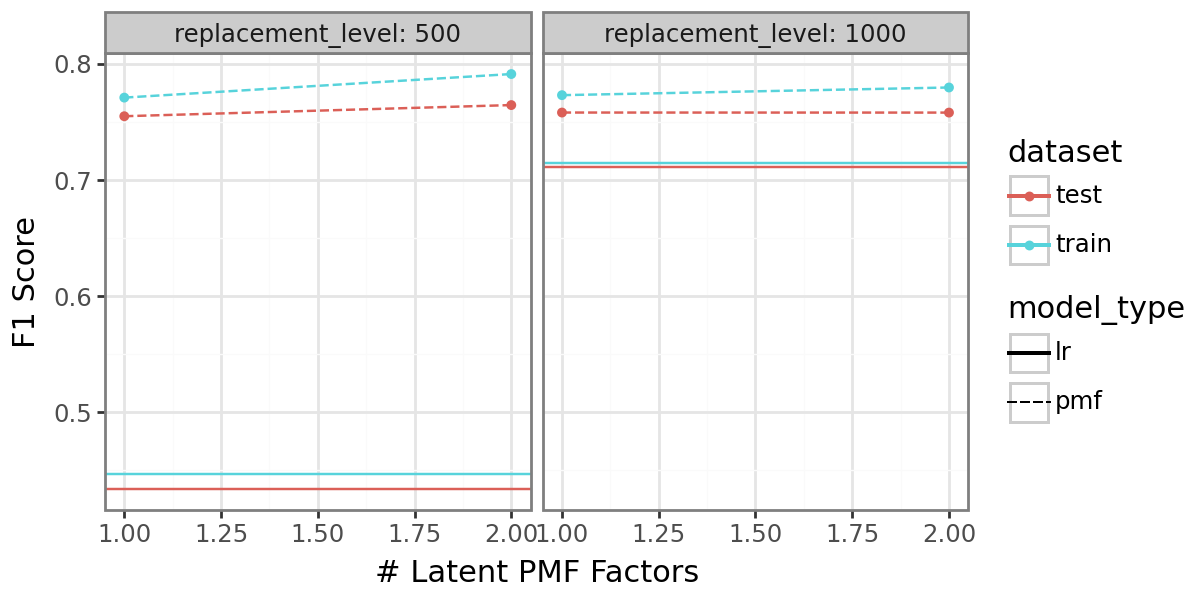

In [7]:
import plotnine
from plotnine import *

plotnine.options.figure_size = (6, 3)
p = (
  metrics
  .pipe(ggplot, aes(x = "num_factors", y = "F1 Score", color = "dataset", linetype = "model_type")) +
  # Add horizontal lines for logistic regression
  geom_hline(aes(yintercept = "F1 Score", color = "dataset"), data = metrics.query("model_type == 'lr'")) +
  # Add lines and points for PMF
  geom_line() +
  geom_point(size = 1, data = metrics.query("model_type == 'pmf'")) +
  facet_wrap("~ replacement_level", labeller="label_both") +
  labs(x = "# Latent PMF Factors", y = "F1 Score") +
  theme_bw()
)

p.save("results/results.png")
p